In [1]:
import rasterio
import rasterio.plot as rplt
import geopandas as gpd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

aois_df = gpd.read_file('avulsion_locations/avulsion_db_4326.shp')

KeyboardInterrupt: 

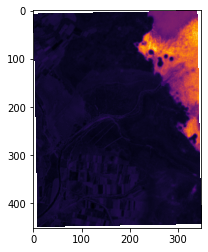

In [5]:
os.makedirs('channel_widths/animations', exist_ok=True)

aois_df = gpd.read_file('avulsion_locations/avulsion_db_4326.shp')

missing = ['ARG_001',
'TAN_002',
'CON_002',
'CON_001',
'KEN_001',
'CHI_001',
'KAZ_001',
'KAZ_007',
'KAZ_014',
'RUS_002',
'RUS_002',
'UZB_001',
'TKMN_001',
'TURK_001',
'JA_90_WA_lake_2003',
'JA_91_Peru',
'JA_92_Casma_Province',
'JA_35_Madagascar_2000',
'JA_38_Madagascar_1994',
'JA_26_Ethiopia_1989_2002_2005_2007',
'JA_37_Somalia_1989',
'JA_28_Eritrea_1997',
'JA_12_Eritrea',
'JA_30_Eritrea_2007',
'JA_36_Eritrea_2005',
'JA_10_Iran_2009',
'JA_94_Iran',
'JA_32_China_1995',
'JA_85_PNG_Gilagil_2007',
'JA_95_PNG_1989',
'JA_69_PNG_2004_2009',
'JA_40_NewGuinea_Madang_1989',
'JA_81_DeinNewGuinea_2002',
'JA_18_PNG_1994',
'TURK_002',
'JA_34_Morocco_2001',
'JA_70_MorobeNewGuinea_1990',
'JA_86_Philippines_1996']

# Create animations
for av in set(aois_df.AV_ID):
    
    if av not in missing:
        continue
    
    av_loc_rows = aois_df.loc[(aois_df.AV_ID==av)]
    row_dat = av_loc_rows.values[0]
    
    channel_widths = glob.glob(os.path.join('channel_widths',av+'*SWI.tif'))

    if len(channel_widths) < 1:
        print("No width data found for "+av)

    ims = []

    fig = plt.figure()
    with rasterio.open(channel_widths[0]) as cwidth:

        for f in range(1, cwidth.count+1):

            im = plt.imshow(cwidth.read(f), animated=True, cmap=plt.get_cmap('inferno'))
            ims.append([im])

        ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                        repeat_delay=1000)

        ani.save(os.path.join('channel_widths/animations',av+'.mp4'))

    plt.close()     

In [3]:
def bcet(band_data):
    s = np.nanmean(np.power(band_data,2)) # mean squared
    e = np.nanmean(band_data)
    l = np.nanmin(band_data)
    h = np.nanmax(band_data)

    L = 0 # output minimum
    H = 3.402823466e+38 # output maximum
    E = (3.402823466e+38/2) # output mean


    # Find b
    b_nom = ((h**2)*(E-L))-(s*(H-L))+((l**2)*(H-E))
    b_den = 2*((h*(E-L))-(e*(H-L))+(l*(H-E)))

    b = b_nom/b_den

    # Find a
    a1 = H-L
    a2 = h-l
    a3 = h+l-(2*b)

    a = a1/(a2*a3)

    # Find c
    c = L-(a*(l-b)**2)

    # Process raster
    return a*((band_data - b)**2) + c


In [4]:
import fiona
from pyproj import Proj, Transformer
from shapely.geometry import Point, LineString, mapping, Polygon
import rasterio.mask
import rasterio.plot as rplt
import math
from skimage.morphology import skeletonize

def get_linevalues(img, affine, coords_y, coords_x, increment=10):

    dims = img.shape
    
    line_values = []
    
    for n in range(1,len(coords_y)):
        
        start_coord = (coords_x[n-1], coords_y[n-1])
        end_coord = (coords_x[n], coords_y[n])

        # Distance between points
        D = math.sqrt(abs(
            (math.pow(abs(end_coord[0]-start_coord[0]),2))-
            (math.pow(abs(end_coord[1]-start_coord[1]),2))
        ))

        d_inc = np.arange(0,D,increment)
        x_coord = lambda d : start_coord[0] + (d/D)*(end_coord[0]-start_coord[0])
        y_coord = lambda d : start_coord[1] + (d/D)*(end_coord[1]-start_coord[1])

        x_range = list(map(x_coord, d_inc))
        y_range = list(map(y_coord, d_inc))

        row, col = ~affine * (np.array(x_range), np.array(y_range)) # x, y to raster coords

        rowcols = zip(np.floor(row).astype(np.uint8), np.floor(col).astype(np.uint8))
        rc_list = list(set(rowcols))

        transect_values = []
        b = np.zeros(img.shape)

        for ix in range(0,len(row)):
            r = int(row[ix])
            c = int(col[ix])
            if (c < dims[0]) and (r < dims[1]):
                b[c, r] = 1
                transect_values.append(img[c, r])

#         skeleton = skeletonize(b)
#         transect_values = img[skeleton>0]
        line_values.extend(transect_values)
    
    return np.array(line_values)


In [38]:
# Which multiple of the standard deviation should we use?

mask_choices = {
    'AFR0211':0.5,
    'ANGO2':0.5,
    'BS0115':1,
    'CA0067':1,
    'JAVA2':1,
    'JAVA3':1,
    'JAVA4':1,
    'JAVA5':0.5,
    'JAVA6':0,
    'JAVA7':0,
    'JAVA8':0.5,
    'JAVA9':1,
    'JAVA12':0,
    'MALAWI1':1,
    'PI0019':1,
    'PI0209':1,
    'PI0769':1,
    'SA0210':1,
    'SA0505':1,
    'SUMA2':1,
    'VENEZ1':0.5,
    'VENEZ2':0.5,
    'CA0194':1,
    'CASP1':0.5
}

BS0115
0     AFR0211
1       ANGO2
2      BS0115
3      CA0067
4       JAVA2
5       JAVA3
6       JAVA4
7       JAVA5
8       JAVA5
9       JAVA5
10      JAVA6
11      JAVA7
12      JAVA7
13      JAVA7
14      JAVA8
15      JAVA9
16     JAVA12
17    MALAWI1
18     PI0019
19     PI0209
20     PI0769
21     SA0210
22     SA0505
23      SUMA2
24     VENEZ1
25     VENEZ2
26     VENEZ2
27     CA0194
28      CASP1
Name: AV_ID, dtype: object


<ipython-input-42-81e3230dcfc7>:71: RuntimeWarning: invalid value encountered in true_divide
  out_image_sum = (out_image_sum-out_ndvi_sum)/out_b5_sum
<ipython-input-42-81e3230dcfc7>:71: RuntimeWarning: invalid value encountered in true_divide
  out_image_sum = (out_image_sum-out_ndvi_sum)/out_b5_sum
<ipython-input-42-81e3230dcfc7>:71: RuntimeWarning: invalid value encountered in true_divide
  out_image_sum = (out_image_sum-out_ndvi_sum)/out_b5_sum
<ipython-input-42-81e3230dcfc7>:71: RuntimeWarning: invalid value encountered in true_divide
  out_image_sum = (out_image_sum-out_ndvi_sum)/out_b5_sum
<ipython-input-42-81e3230dcfc7>:71: RuntimeWarning: invalid value encountered in true_divide
  out_image_sum = (out_image_sum-out_ndvi_sum)/out_b5_sum
<ipython-input-42-81e3230dcfc7>:71: RuntimeWarning: invalid value encountered in true_divide
  out_image_sum = (out_image_sum-out_ndvi_sum)/out_b5_sum
<ipython-input-42-81e3230dcfc7>:71: RuntimeWarning: invalid value encountered in true_divide
 

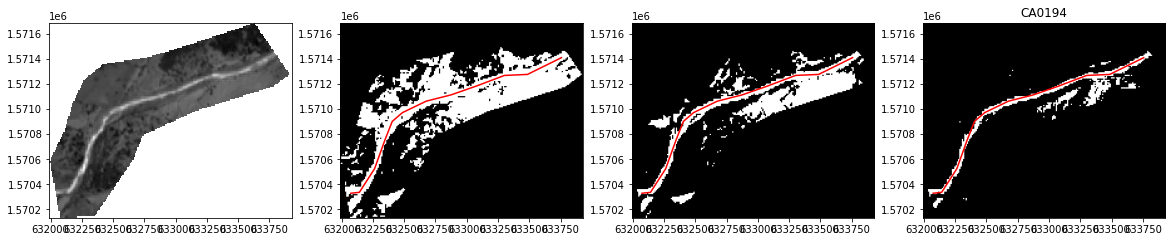

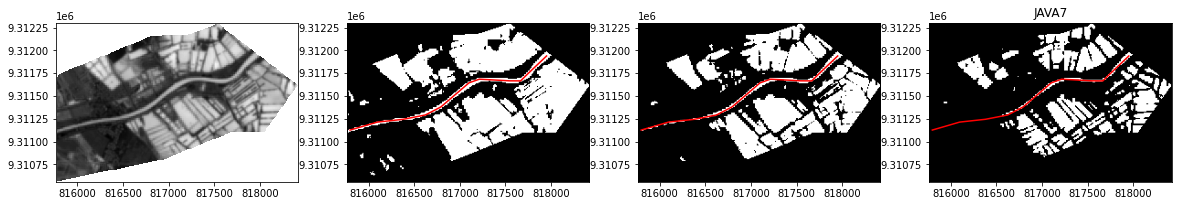

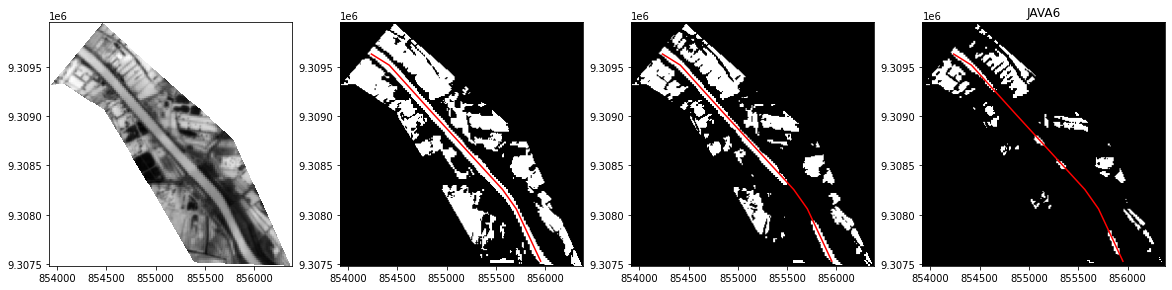

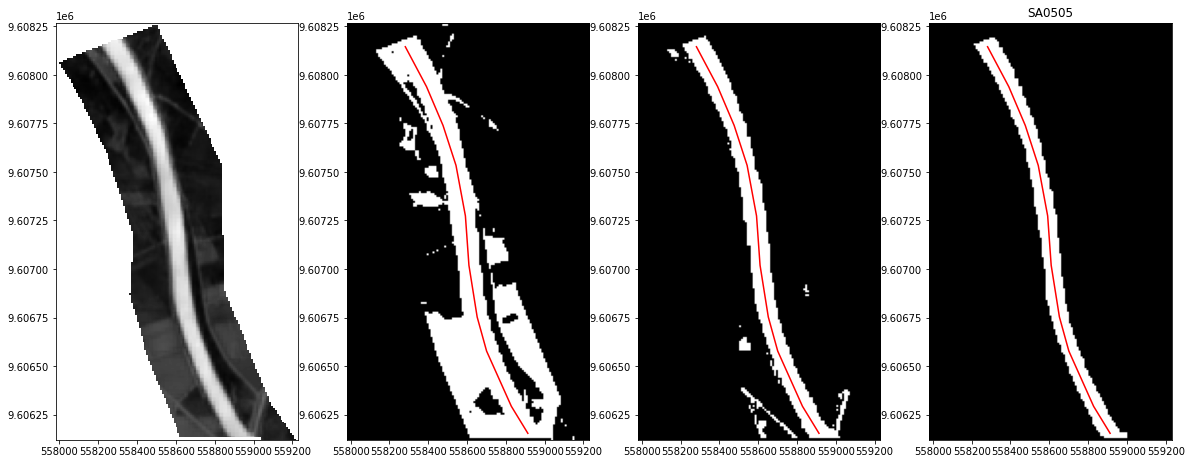

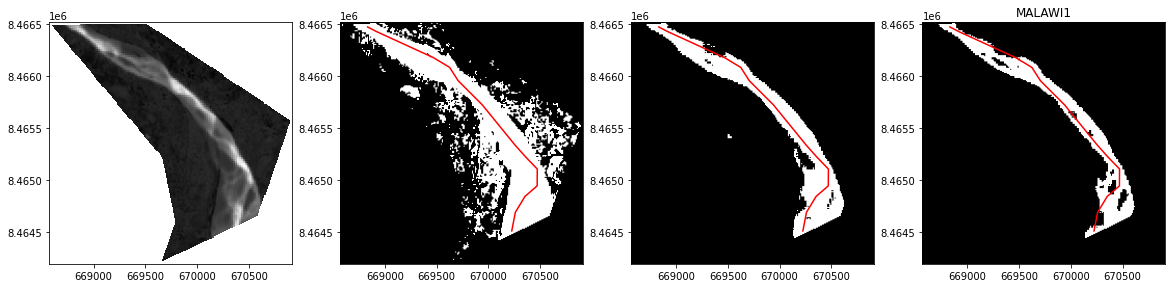

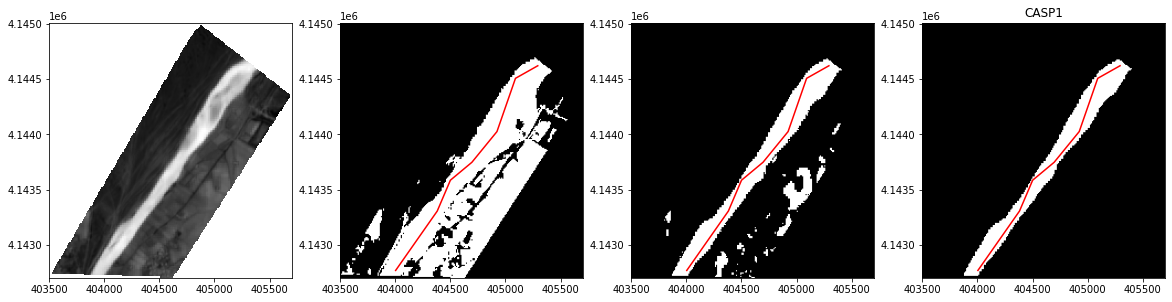

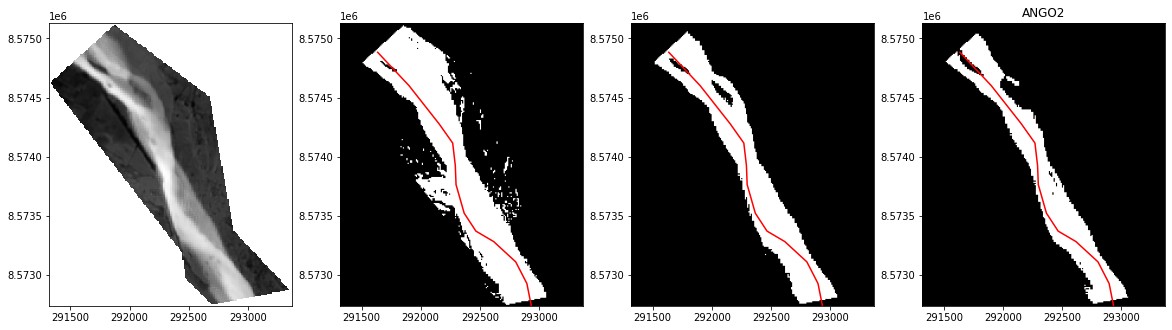

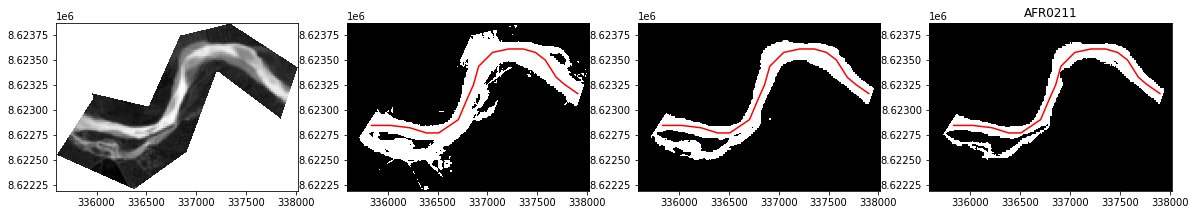

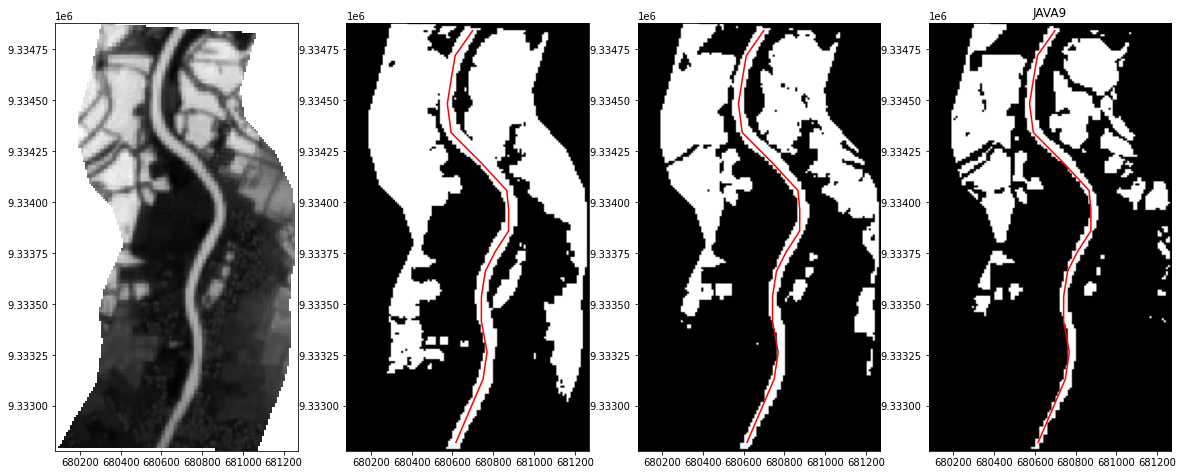

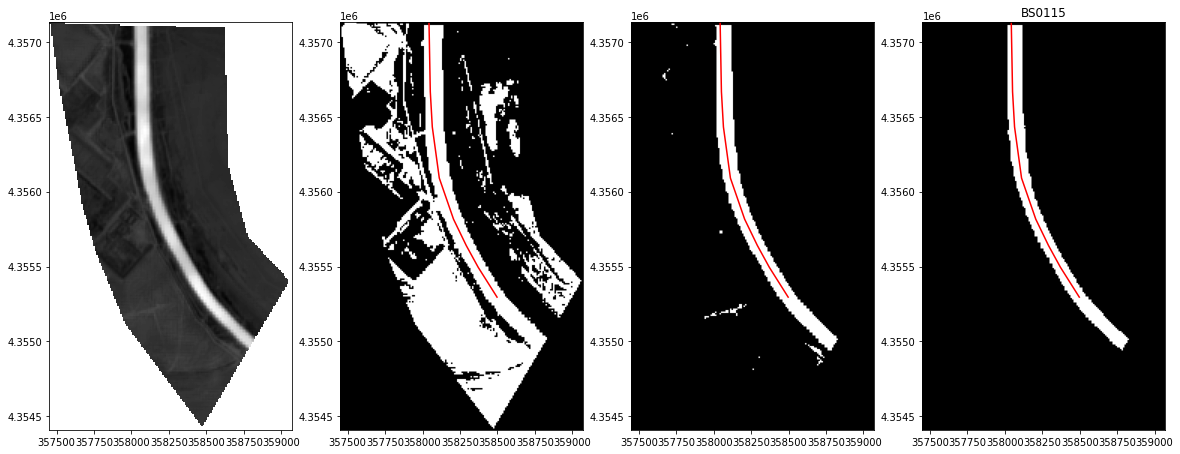

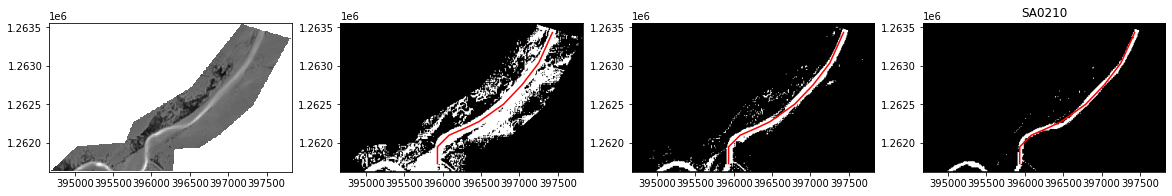

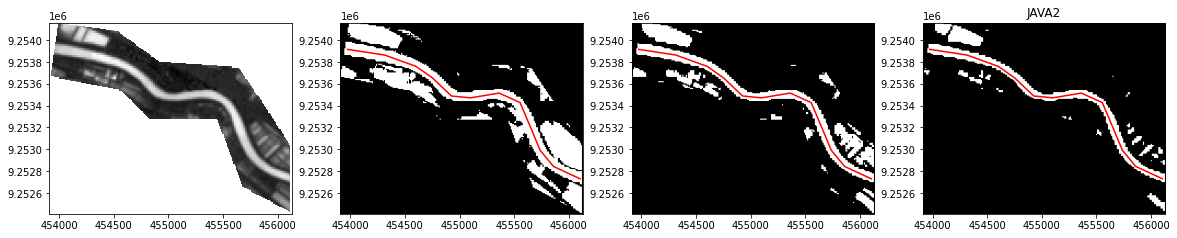

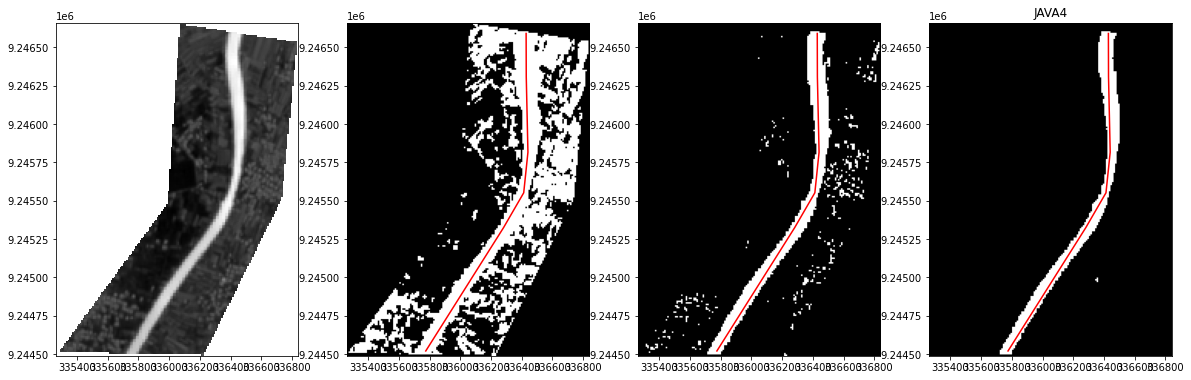

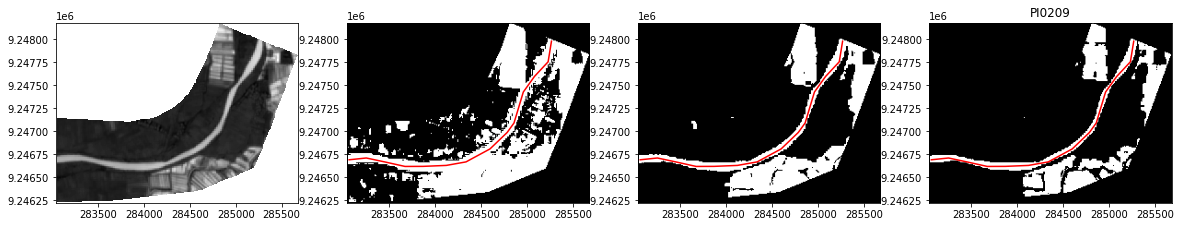

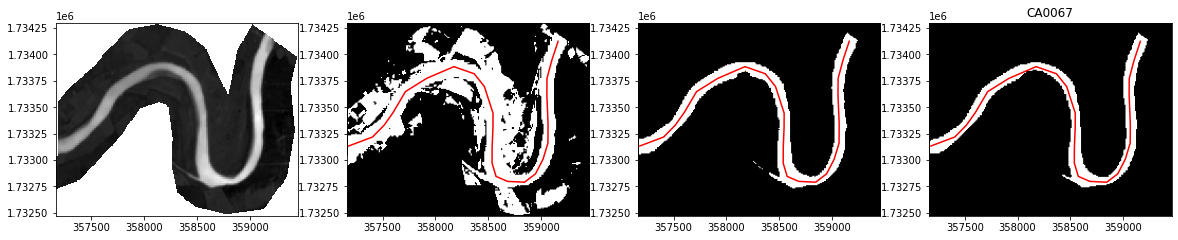

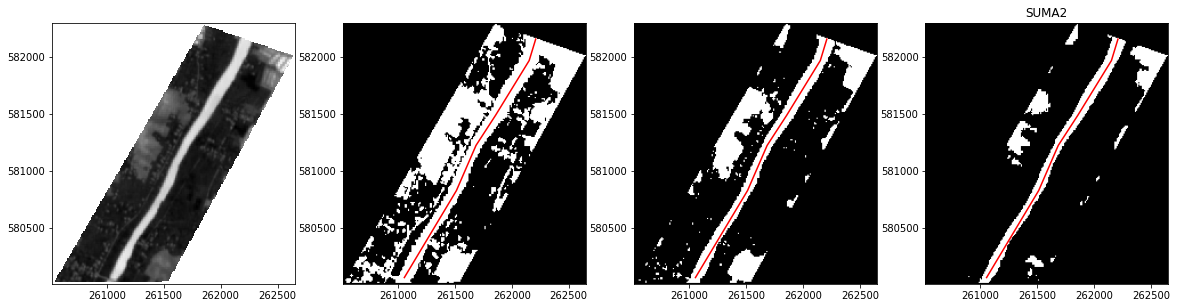

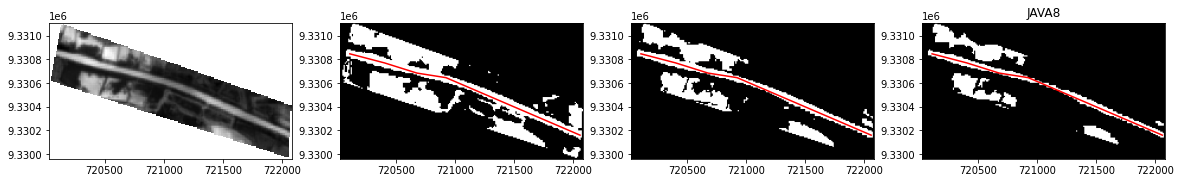

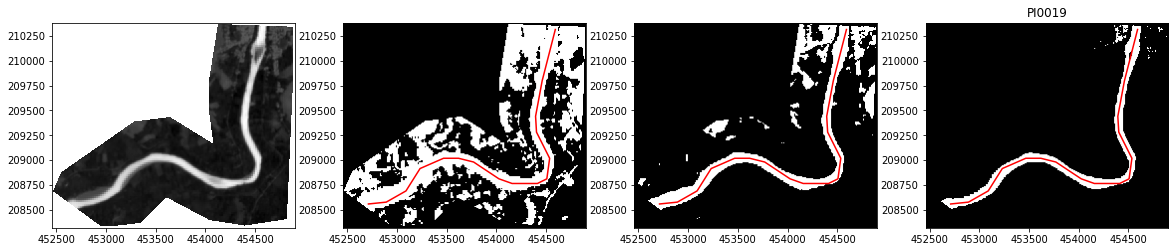

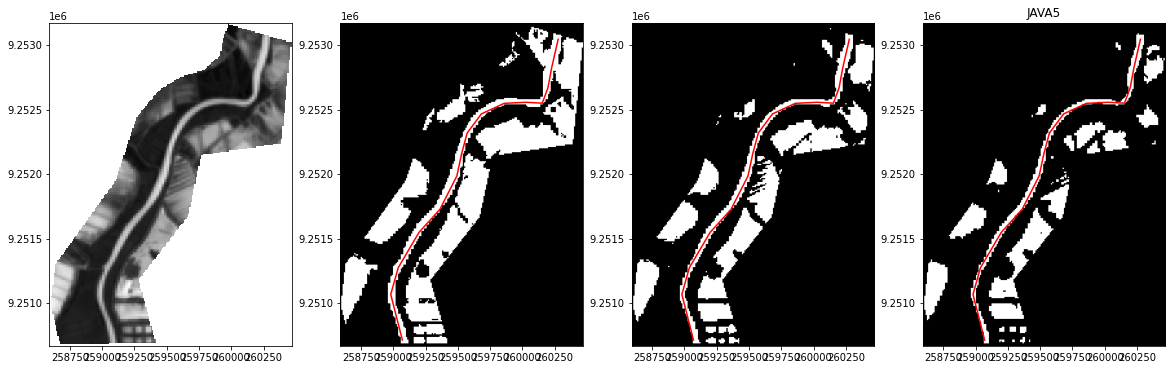

In [42]:

# Extract channel widths
av = aois_df.AV_ID.values[2]
print(av)

# Channel centrelines
centerlines = os.path.join('avulsion_locations', 'channel_width_centrelines.shp')

# Channel envelope
envelopes = os.path.join('avulsion_locations', 'river_channel_isolation.shp')

# Channel width estimates
width_estimates = os.path.join('avulsion_locations', 'channel_width_estimates.shp')

print(aois_df.AV_ID)

for av1 in set(aois_df.AV_ID):
    
    centerlines_df = gpd.read_file(centerlines)
    
    envelopes_df = gpd.read_file(envelopes)
    
    width_estimates_df = gpd.read_file(width_estimates)
    
    envelope_geom = Polygon(envelopes_df.loc[(envelopes_df.avulsion==av1)].values[0][2])
    centerline_geom = LineString(centerlines_df.loc[(centerlines_df.avulsion==av1)].values[0][2])
    width_est = width_estimates_df.loc[(width_estimates_df.avulsion==av1)].values[0][2]
        
    channel_width_stack = glob.glob(os.path.join('channel_widths',av1+'*_SWI.tif'))
    channel_ndwi_stack = glob.glob(os.path.join('channel_widths',av1+'*_NDWI.tif'))
    channel_b5_stack = glob.glob(os.path.join('channel_widths',av1+'*_B5.tif'))
    
    with rasterio.open(channel_width_stack[0]) as stk:
        
        with rasterio.open(channel_ndwi_stack[0]) as ndwitk:
            
            with rasterio.open(channel_b5_stack[0]) as b5vitk:
                
                inProj = Proj('epsg:4326')
                outProj = stk.profile['crs']
                transformer = Transformer.from_crs(4326, outProj.to_epsg())

                polygon_coords = []
                linestring_coords_x = []
                linestring_coords_y = []

                for coords in mapping(envelope_geom)['coordinates'][0]:
                    x_utm,y_utm = transformer.transform(coords[1], coords[0])
                    polygon_coords.append((x_utm,y_utm))

                for coords in mapping(centerline_geom)['coordinates']:
                    x_utm,y_utm = transformer.transform(coords[1], coords[0])
                    linestring_coords_y.append(y_utm)
                    linestring_coords_x.append(x_utm)

                polygon_cutline = Polygon(polygon_coords)

                out_image, out_transform = rasterio.mask.mask(stk, [polygon_cutline], crop=True)

                out_image_ndwi, out_transform_ndwi = rasterio.mask.mask(ndwitk, [polygon_cutline], crop=True)

                out_image_b5, out_transform_b5 = rasterio.mask.mask(b5vitk, [polygon_cutline], crop=True)

                linevalues = get_linevalues(out_image, out_transform, linestring_coords_y, linestring_coords_x)

                out_size = np.shape(out_image)

                out_image_sum = np.divide(np.nansum(out_image, axis=0), out_size[0])
                out_ndwi_sum = np.divide(np.nansum(out_image_ndwi, axis=0), out_size[0])
                out_b5_sum = np.divide(np.nansum(out_image_b5, axis=0), out_size[0])
                
                out_image_sum = (out_image_sum-out_ndwi_sum)/out_b5_sum

                fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,10))
                image_hidden = ax[0].imshow(out_image_sum, cmap='gray')

                out_image_sum[out_image_sum==0] = np.nan
        #         out_image_sum = bcet(out_image_sum)
                rplt.show(out_image_sum, ax=ax[0], transform=out_transform, cmap='gray')

                inf_array = np.isinf(out_image_sum)
                not_inf_array = ~ inf_array
                out_image_sum_no_inf = out_image_sum[not_inf_array]
                out_image_sum_no_nan = out_image_sum_no_inf[~np.isnan(out_image_sum_no_inf)]

                img_std = np.std(out_image_sum_no_nan)
                img_median = np.median(out_image_sum_no_nan)

#                 ax[1].hist(out_image_sum_no_nan, bins=30)
#                 ax[1].hist(linevalues, bins=30)
#                 ax[1].plot([img_median, img_median], [0, 5000], 'k-')
#                 ax[1].plot([img_median-img_std, img_median-img_std], [0, 5000], 'k--')
#                 ax[1].plot([img_median+img_std, img_median+img_std], [0, 5000], 'k--')

                os.makedirs('channel_widths/'+av1, exist_ok=True)

                out_profile = ndwitk.profile.copy()
                
                new_size = out_image_sum.shape
                
                out_profile.update({
                    'transform':out_transform,
                    'dtype': np.uint8,
                    'height': new_size[0],
                    'width': new_size[1],
                    'nodata':0
                })

                water_mask_file = os.path.join('channel_widths', av1, av1+'_water_mask.tif')

                if os.path.exists(std0_file):
                    os.remove(std0_file)

                if os.path.exists(std0_5_file):
                    os.remove(std0_5_file)

                if os.path.exists(std1_file):
                    os.remove(std1_file)

                out_image_range_0 = (out_image_sum>=img_median)
                out_image_range_0_5= (out_image_sum>=img_median+(img_std/2))
                out_image_range_1 = (out_image_sum>=img_median+img_std)

                out_image_range_choice = (out_image_sum>=img_median+(img_std*mask_choices[av1]))
                
#                 print(out_profile)
#                 with rasterio.open(std0_file, 'w', nbits=1, **out_profile) as dst:
#                     dst.write(out_image_range_0.astype(np.uint8), 1)

#                 with rasterio.open(std0_5_file, 'w', nbits=1, **out_profile) as dst:
#                     dst.write(out_image_range_0_5.astype(np.uint8), 1)

                with rasterio.open(water_mask_file, 'w', nbits=1, **out_profile) as dst:
                    dst.write(out_image_range_choice.astype(np.uint8), 1)

                rplt.show(out_image_range_0, ax=ax[1], transform=out_transform, cmap='gray')
                ax[1].plot(linestring_coords_x, linestring_coords_y, 'r-')
        
                rplt.show(out_image_range_0_5, ax=ax[2], transform=out_transform, cmap='gray')
                ax[2].plot(linestring_coords_x, linestring_coords_y, 'r-')

                rplt.show(out_image_range_1, ax=ax[3], transform=out_transform, cmap='gray')
                ax[3].plot(linestring_coords_x, linestring_coords_y, 'r-')

                plt.title(av1)
    #             plt.show()
    #             plt.close()

In [65]:
from shapely.geometry import shape, mapping
import csv

# Get channel widths by pixel mask

gtdb = gpd.read_file('channel_widths/global_width_transects.shp')

for av1 in set(aois_df.AV_ID):
    
    rows = gtdb.loc[gtdb.river == av1]
    
    increment = 5
    
    with rasterio.open(os.path.join('channel_widths', av1, av1+'_water_mask.tif')) as wtk_src:
        epsg = wtk_src.profile['crs'].to_epsg()
        
        row_utm = rows.to_crs({'init': 'epsg:'+str(epsg)})

        band1 = wtk_src.read()
        sband = band1[0]
        affine = wtk_src.transform
        dims = sband.shape
        
        transect_widths = np.zeros((1,len(row_utm)))
        
        count = 0
        for rdx, row in row_utm.iterrows():
            
            transect = mapping(row.geometry)
            
            if transect:

                start_coord = transect['coordinates'][0]
                end_coord = transect['coordinates'][-1]

                # Distance between points
                D = math.sqrt(abs(
                    (math.pow(abs(end_coord[0]-start_coord[0]),2))-
                    (math.pow(abs(end_coord[1]-start_coord[1]),2))
                ))

                d_inc = np.arange(0,D,increment)
                x_coord = lambda d : start_coord[0] + (d/D)*(end_coord[0]-start_coord[0])
                y_coord = lambda d : start_coord[1] + (d/D)*(end_coord[1]-start_coord[1])

                x_range = list(map(x_coord, d_inc))
                y_range = list(map(y_coord, d_inc))

                row, col = ~affine * (np.array(x_range), np.array(y_range)) # x, y to raster coords

                rowcols = zip(np.floor(row).astype(np.uint8), np.floor(col).astype(np.uint8))
                rc_list = list(set(rowcols))

                transect_values = []
                b = np.zeros(sb
                             and.shape)

                for ix in range(0,len(row)):
                    r = int(row[ix])
                    c = int(col[ix])
                    if (c < dims[0]) and (r < dims[1]):
                        b[c, r] = 1
                        transect_values.append(sband[c, r])

                skeleton = skeletonize(b)
                transect_values = sband[skeleton>0]
                tv = np.array(transect_values)

                transect_width = len(tv[tv>0])*affine[0]
                       
                if transect_width > 15:
                    transect_widths[0, count] = transect_width
                    
                count = count+1

        channel_width_recorded_file = os.path.join('channel_widths', av1, av1+'_channel_widths.csv')

        if os.path.exists(channel_width_recorded_file):
            os.remove(channel_width_recorded_file)
        
        print('Outputting to '+channel_width_recorded_file)
        with open(channel_width_recorded_file, 'w', newline="\n") as width_records:

            csv_writer = csv.writer(width_records, delimiter=',',
                                    quotechar='|', quoting=csv.QUOTE_MINIMAL)
            
            for tw in transect_widths:
                csv_writer.writerow(tw)



Outputting to channel_widths/CA0194/CA0194_channel_widths.csv
Outputting to channel_widths/JAVA7/JAVA7_channel_widths.csv
Outputting to channel_widths/JAVA6/JAVA6_channel_widths.csv
Outputting to channel_widths/SA0505/SA0505_channel_widths.csv
Outputting to channel_widths/MALAWI1/MALAWI1_channel_widths.csv
Outputting to channel_widths/CASP1/CASP1_channel_widths.csv
Outputting to channel_widths/ANGO2/ANGO2_channel_widths.csv
Outputting to channel_widths/AFR0211/AFR0211_channel_widths.csv
Outputting to channel_widths/JAVA9/JAVA9_channel_widths.csv
Outputting to channel_widths/BS0115/BS0115_channel_widths.csv
Outputting to channel_widths/JAVA3/JAVA3_channel_widths.csv
Outputting to channel_widths/SA0210/SA0210_channel_widths.csv
Outputting to channel_widths/PI0769/PI0769_channel_widths.csv
Outputting to channel_widths/JAVA2/JAVA2_channel_widths.csv
Outputting to channel_widths/JAVA4/JAVA4_channel_widths.csv
Outputting to channel_widths/PI0209/PI0209_channel_widths.csv
Outputting to channe